# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.joe,
#    parameters=np.array([[2.5]]), rotation=90
#    )


#copula_pv = pv.Bicop(
#    family=pv.BicopFamily.clayton,
#    parameters=np.array([[2.0]]), rotation=0
#    )


copula_pv = pv.Bicop(
    family=pv.BicopFamily.bb1,
    parameters=np.array([[1.2],[2.0]]),
    rotation=0
)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_131389/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_131389/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_131389/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None
        )
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-19 18:31:24,947] A new study created in RDB with name: no-name-0638cf11-5998-4acf-b70f-bf70fc4419c2
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ


current_loss: tensor(1.4370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<32:16,  1.03it/s]

current_loss: tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4396765232086182
current_loss: tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3949, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:01<20:17,  1.64it/s]

current_loss_val:  1.434019923210144
current_loss: tensor(1.3949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<11:08,  2.99it/s]

current_loss_val:  1.4343433380126953
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4364714622497559


  0%|          | 6/2000 [00:01<10:56,  3.04it/s]


current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4366543292999268
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4365724325180054
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4365348815917969
Early Stop at iteration 6 with minimal loss tensor(1.4340, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 1/2000 [00:00<04:08,  8.03it/s]

current_loss: tensor(1.3961, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3829212188720703
current_loss: tensor(1.3535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:11,  6.41it/s]

current_loss_val:  1.249826192855835
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2925, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:32,  4.42it/s]

current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2003272771835327
current_loss: tensor(1.2281, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<08:05,  4.11it/s]

current_loss: tensor(1.2023, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1769793033599854
current_loss: tensor(1.2023, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:17,  4.56it/s]

current_loss: tensor(1.1917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1629339456558228
current_loss: tensor(1.1917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1816, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:46,  4.90it/s]

current_loss_val:  1.1473851203918457
current_loss: tensor(1.1816, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1315996646881104


  0%|          | 8/2000 [00:01<06:47,  4.89it/s]

current_loss: tensor(1.1734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.118711233139038


  0%|          | 9/2000 [00:01<07:13,  4.59it/s]

current_loss: tensor(1.1640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.112212896347046


  0%|          | 10/2000 [00:02<07:28,  4.44it/s]

current_loss: tensor(1.1581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0910574197769165


  1%|          | 11/2000 [00:02<07:35,  4.36it/s]

current_loss: tensor(1.1419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0839763879776
current_loss: tensor(1.1365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<09:48,  3.38it/s]

current_loss_val:  1.0818556547164917
current_loss: tensor(1.1309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<11:33,  2.86it/s]

current_loss: tensor(1.1265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0821589231491089
current_loss: tensor(1.1265, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1192, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<11:37,  2.85it/s]

current_loss_val:  1.0805766582489014
current_loss: tensor(1.1192, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1144, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:04<09:17,  3.56it/s]

current_loss_val:  1.0816762447357178
current_loss: tensor(1.1144, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0748146772384644
current_loss: tensor(1.1020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0990, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<09:28,  3.49it/s]

current_loss_val:  1.075286626815796
current_loss: tensor(1.0990, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<09:01,  3.66it/s]

current_loss_val:  1.0747244358062744
current_loss: tensor(1.0956, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0939, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<09:07,  3.62it/s]

current_loss_val:  1.073714017868042
current_loss: tensor(1.0939, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0918, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:05<09:14,  3.57it/s]

current_loss_val:  1.0735799074172974
current_loss: tensor(1.0918, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:05<10:14,  3.22it/s]

current_loss: tensor(1.0897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0739314556121826
current_loss: tensor(1.0897, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0867, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<12:18,  2.68it/s]

current_loss_val:  1.0734820365905762
current_loss: tensor(1.0867, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0803, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:06<11:59,  2.75it/s]

current_loss_val:  1.0765891075134277
current_loss: tensor(1.0803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:06<10:38,  3.09it/s]

current_loss_val:  1.0791575908660889
current_loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:07<11:06,  2.96it/s]

current_loss: tensor(1.0756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0791949033737183


  1%|▏         | 26/2000 [00:07<10:12,  3.22it/s]

current_loss: tensor(1.0756, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0791430473327637


  1%|▏         | 26/2000 [00:07<09:32,  3.45it/s]

current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0775049924850464
Early Stop at iteration 26 with minimal loss tensor(1.0735, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:31:41,616] Trial 0 finished with value: -2.1469638347625732 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.032124229114313, 'penalty_decorrelation_ridge_second_difference': 16.786156837976037}. Best is trial 0 with value: -2.1469638347625732.
  0%|          | 1/2000 [00:00<06:07,  5.44it/s]

current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0724458694458008
current_loss: tensor(1.0651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:03,  6.57it/s]

current_loss_val:  1.069303274154663
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0606735944747925
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:41,  9.01it/s]

current_loss_val:  1.0591838359832764
current_loss: tensor(1.0545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0582696199417114
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0561039447784424


  0%|          | 7/2000 [00:00<03:49,  8.67it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0565847158432007
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:38,  9.11it/s]

current_loss_val:  1.056882381439209
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587503910064697
current_loss: tensor(1.0481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0580625534057617


  0%|          | 10/2000 [00:01<04:15,  7.79it/s]


current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0579934120178223
Early Stop at iteration 10 with minimal loss tensor(1.0561, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:31:44,501] Trial 1 finished with value: -2.1122076511383057 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.8990586744942535, 'penalty_decorrelation_ridge_second_difference': 0.1914521339951969}. Best is trial 1 with value: -2.1122076511383057.
  0%|          | 1/2000 [00:00<05:13,  6.37it/s]

current_loss: tensor(1.0876, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0734922885894775
current_loss: tensor(1.0873, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0853, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:25,  7.51it/s]

current_loss_val:  1.0726405382156372
current_loss: tensor(1.0853, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0728745460510254
current_loss: tensor(1.0848, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<05:16,  6.30it/s]

current_loss: tensor(1.0842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730302333831787
current_loss: tensor(1.0842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:54,  6.76it/s]

current_loss_val:  1.0720528364181519
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0715395212173462


  0%|          | 7/2000 [00:01<05:56,  5.59it/s]

current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0733931064605713


  0%|          | 8/2000 [00:01<06:10,  5.38it/s]

current_loss: tensor(1.0761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0713988542556763


  0%|          | 9/2000 [00:01<06:12,  5.35it/s]

current_loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0707736015319824
current_loss: tensor(1.0723, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:51,  5.67it/s]

current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070955514907837
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0842, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<06:24,  5.18it/s]

current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072559118270874
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<05:33,  5.95it/s]

current_loss_val:  1.0723170042037964
current_loss: tensor(1.0667, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0720640420913696
current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<05:57,  5.55it/s]


current_loss: tensor(1.0643, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0722293853759766
Early Stop at iteration 13 with minimal loss tensor(1.0708, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:31:48,121] Trial 2 finished with value: -2.141547441482544 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.552770324960797, 'penalty_decorrelation_ridge_second_difference': 1.8209683057868542}. Best is trial 1 with value: -2.1122076511383057.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0713, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:15,  4.03it/s]

current_loss_val:  1.0727368593215942
current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0725992918014526


  0%|          | 3/2000 [00:00<07:37,  4.37it/s]

current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0721794366836548
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:19,  6.24it/s]

current_loss: tensor(1.0665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0685547590255737
current_loss: tensor(1.0665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067032814025879
current_loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:18,  7.70it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.065066933631897
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0646123886108398
current_loss: tensor(1.0618, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:52,  8.56it/s]

current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0651311874389648
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064083456993103
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:39,  9.06it/s]

current_loss: tensor(1.0586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0634026527404785
current_loss: tensor(1.0586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0632959604263306
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:38,  9.08it/s]

current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063382625579834
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0627334117889404
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<03:31,  9.38it/s]

current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062973976135254
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0629287958145142
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<03:29,  9.48it/s]

current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0609856843948364
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0610376596450806
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:28,  9.52it/s]

current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0608259439468384
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591413974761963
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:36,  9.15it/s]

current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591665506362915
current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0590931177139282


  1%|          | 22/2000 [00:02<03:47,  8.71it/s]

current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0589251518249512
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<04:36,  7.15it/s]

current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0586304664611816
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:03<04:22,  7.54it/s]

current_loss_val:  1.0583816766738892
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0578935146331787
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<03:58,  8.28it/s]

current_loss_val:  1.0565783977508545
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.055963397026062
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<04:03,  8.09it/s]

current_loss_val:  1.0522689819335938
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.051665186882019
current_loss: tensor(1.0467, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<04:12,  7.80it/s]

current_loss: tensor(1.0463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0507183074951172
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:04<04:04,  8.03it/s]

current_loss_val:  1.0493254661560059
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.048662781715393
current_loss: tensor(1.0416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:04<03:48,  8.62it/s]

current_loss_val:  1.048447847366333
current_loss: tensor(1.0413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0476700067520142
current_loss: tensor(1.0411, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:04<03:56,  8.32it/s]

current_loss_val:  1.0476675033569336
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0472984313964844


  2%|▏         | 37/2000 [00:04<05:12,  6.28it/s]

current_loss: tensor(1.0407, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0462627410888672
current_loss: 

  2%|▏         | 38/2000 [00:05<06:22,  5.13it/s]

tensor(1.0401, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0453413724899292
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:05<07:04,  4.62it/s]

current_loss_val:  1.04434335231781
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:05<10:01,  3.26it/s]

current_loss_val:  1.043764591217041
current_loss: tensor(1.0388, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:06<10:53,  3.00it/s]

current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0436023473739624
current_loss: tensor(1.0385, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:06<11:56,  2.73it/s]

current_loss_val:  1.0436811447143555
current_loss: tensor(1.0382, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:07<11:46,  2.77it/s]

current_loss_val:  1.0433090925216675
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:07<12:27,  2.62it/s]

current_loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0426541566848755
current_loss: tensor(1.0375, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0371, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:08<13:50,  2.35it/s]

current_loss_val:  1.0423624515533447
current_loss: tensor(1.0371, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:08<14:29,  2.25it/s]

current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0415611267089844
current_loss: tensor(1.0363, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:09<15:31,  2.10it/s]

current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0417932271957397
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:09<16:19,  1.99it/s]

current_loss_val:  1.0417335033416748
current_loss: tensor(1.0360, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:10<15:37,  2.08it/s]

current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.041635513305664
current_loss: tensor(1.0348, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:10<16:08,  2.01it/s]

current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0412410497665405
current_loss: tensor(1.0346, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:10<12:47,  2.54it/s]

current_loss_val:  1.041177749633789
current_loss: tensor(1.0343, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:11<11:42,  2.77it/s]

current_loss_val:  1.0409324169158936
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:11<10:41,  3.03it/s]

current_loss_val:  1.0403647422790527
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:11<11:32,  2.81it/s]

current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0406172275543213


  3%|▎         | 55/2000 [00:11<10:36,  3.05it/s]

current_loss: tensor(1.0326, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0405651330947876
current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:12<11:57,  2.71it/s]

current_loss_val:  1.0398764610290527
current_loss: tensor(1.0317, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:12<13:18,  2.43it/s]

current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0400139093399048
current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:13<13:50,  2.34it/s]

current_loss_val:  1.0396653413772583
current_loss: tensor(1.0311, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0308, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:13<12:49,  2.52it/s]

current_loss_val:  1.0394223928451538
current_loss: tensor(1.0308, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:14<12:18,  2.63it/s]

current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0391048192977905
current_loss: tensor(1.0303, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0307, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:14<13:57,  2.32it/s]

current_loss: tensor(1.0300, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0384639501571655
current_loss: tensor(1.0300, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:15<14:27,  2.23it/s]

current_loss: tensor(1.0297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.038321852684021
current_loss: tensor(1.0297, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0294, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 63/2000 [00:15<13:38,  2.37it/s]

current_loss_val:  1.0380792617797852
current_loss: tensor(1.0294, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 64/2000 [00:15<13:44,  2.35it/s]

current_loss: tensor(1.0292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0373674631118774
current_loss: tensor(1.0292, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0289, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 65/2000 [00:16<12:38,  2.55it/s]

current_loss_val:  1.037457823753357
current_loss: tensor(1.0289, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 66/2000 [00:16<11:02,  2.92it/s]

current_loss_val:  1.0373667478561401
current_loss: tensor(1.0288, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0283, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 67/2000 [00:16<10:34,  3.05it/s]

current_loss_val:  1.0369560718536377
current_loss: tensor(1.0283, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0282, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 68/2000 [00:17<10:28,  3.07it/s]

current_loss_val:  1.0364421606063843
current_loss: tensor(1.0282, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 69/2000 [00:17<10:23,  3.10it/s]

current_loss_val:  1.0367398262023926
current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 70/2000 [00:17<10:14,  3.14it/s]

current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0367193222045898
current_loss: tensor(1.0280, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 71/2000 [00:18<11:49,  2.72it/s]

current_loss: tensor(1.0278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.036725401878357


  4%|▎         | 72/2000 [00:18<11:18,  2.84it/s]

current_loss: tensor(1.0278, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0367937088012695
current_loss: tensor(1.0277, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0277, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 72/2000 [00:18<08:28,  3.79it/s]

current_loss: tensor(1.0275, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0368719100952148
Early Stop at iteration 72 with minimal loss tensor(1.0364, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:08,351] Trial 3 finished with value: -2.0728843212127686 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.414761655084025, 'penalty_decorrelation_ridge_second_difference': 10.365831778993439}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0630, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<20:13,  1.65it/s]

current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0726019144058228
current_loss: tensor(1.0601, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<12:30,  2.66it/s]

current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0723323822021484
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:18,  4.00it/s]

current_loss_val:  1.0716074705123901
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.066545009613037


  0%|          | 5/2000 [00:01<08:15,  4.03it/s]

current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0639468431472778


  0%|          | 6/2000 [00:01<07:37,  4.36it/s]

current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0632845163345337
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:36,  5.03it/s]

current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0609245300292969
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<06:00,  5.53it/s]

current_loss_val:  1.059144377708435
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0585545301437378
current_loss: tensor(1.0483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<05:49,  5.69it/s]

current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056362509727478
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<05:26,  6.08it/s]

current_loss_val:  1.0560826063156128
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<06:06,  5.43it/s]

current_loss_val:  1.0564701557159424
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<07:22,  4.49it/s]

current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056560754776001
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:39,  4.32it/s]

current_loss: tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0568362474441528
current_loss: 

  1%|          | 15/2000 [00:03<07:35,  4.36it/s]

tensor(1.0430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0577569007873535
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:48,  4.23it/s]


current_loss_val:  1.0574002265930176
Early Stop at iteration 15 with minimal loss tensor(1.0561, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:32:12,945] Trial 4 finished with value: -2.1121649742126465 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.7693690100603938, 'penalty_decorrelation_ridge_second_difference': 12.623874219340747}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<05:43,  5.83it/s]

current_loss: tensor(1.0925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1188, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0908, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0733060836791992
current_loss: tensor(1.0908, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:16,  7.79it/s]

current_loss: tensor(1.0902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.073322057723999
current_loss: tensor(1.0902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0737438201904297


  0%|          | 4/2000 [00:00<05:02,  6.60it/s]

current_loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0734009742736816
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:43,  5.80it/s]

current_loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0734788179397583
current_loss: tensor(1.0830, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:51,  4.85it/s]

current_loss: tensor(1.0783, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0760860443115234
Early Stop at iteration 5 with minimal loss tensor(1.0733, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:15,039] Trial 5 finished with value: -2.1466121673583984 and parameters: {'penalty_decorrelation_ridge_first_difference': 24.299196765943734, 'penalty_decorrelation_ridge_second_difference': 29.21326091036567}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<12:50,  2.59it/s]

current_loss: tensor(1.0671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0726385116577148
current_loss: tensor(1.0671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:21,  5.23it/s]

current_loss_val:  1.0723713636398315
current_loss: tensor(1.0666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0717763900756836
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:43,  4.94it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0678457021713257
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:29,  3.92it/s]

current_loss: tensor(1.0641, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0653599500656128
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:37,  5.01it/s]

current_loss_val:  1.0638271570205688
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0604451894760132


  0%|          | 8/2000 [00:01<06:10,  5.37it/s]

current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0589393377304077
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<06:01,  5.51it/s]

current_loss_val:  1.0601261854171753
current_loss: tensor(1.0525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058579444885254


  1%|          | 11/2000 [00:02<08:10,  4.06it/s]

current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0586280822753906
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<06:01,  5.50it/s]

current_loss_val:  1.0600807666778564
current_loss: tensor(1.0504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059256911277771
current_loss: tensor(1.0499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<06:55,  4.78it/s]

current_loss_val:  1.0591338872909546
current_loss: tensor(1.0498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591024160385132
Early Stop at iteration 14 with minimal loss tensor(1.0586, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:18,883] Trial 6 finished with value: -2.1171584129333496 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.7462118269726234, 'penalty_decorrelation_ridge_second_difference': 9.436594320010713}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<05:20,  6.23it/s]

current_loss: tensor(1.0901, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732083320617676
current_loss: tensor(1.0886, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 3/2000 [00:00<04:21,  7.63it/s]

tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732508897781372
current_loss: tensor(1.0880, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0849, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730196237564087
current_loss: tensor(1.0849, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:10,  7.96it/s]

current_loss: tensor(1.0837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0751047134399414
current_loss: tensor(1.0837, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0735939741134644
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:08,  8.01it/s]

current_loss: tensor(1.0803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072540283203125
current_loss: tensor(1.0803, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0723577737808228
current_loss: 

  0%|          | 8/2000 [00:01<04:06,  8.09it/s]

tensor(1.0794, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072345495223999
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:48,  6.89it/s]

current_loss_val:  1.0718538761138916
current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0724279880523682


  1%|          | 11/2000 [00:01<04:59,  6.63it/s]

current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.071964144706726
current_loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<04:51,  6.83it/s]

current_loss: tensor(1.0678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0721992254257202
current_loss: tensor(1.0678, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<05:48,  5.69it/s]

current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0710833072662354
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<05:45,  5.75it/s]

current_loss_val:  1.0706369876861572
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0696399211883545


  1%|          | 16/2000 [00:02<06:07,  5.40it/s]

current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0693671703338623
current_loss: tensor(1.0627, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:48,  5.69it/s]

current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0682721138000488
current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<05:37,  5.88it/s]

current_loss_val:  1.0625290870666504
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<05:48,  5.69it/s]

current_loss_val:  1.061364769935608
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.06106436252594
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<05:34,  5.91it/s]

current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059256672859192
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<07:02,  4.68it/s]

current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0593831539154053


  1%|          | 23/2000 [00:03<06:59,  4.71it/s]

current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0592730045318604
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<05:47,  5.69it/s]

current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0582878589630127
current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057354211807251


  1%|▏         | 26/2000 [00:04<05:29,  5.98it/s]

current_loss: tensor(1.0561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056458592414856
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<05:31,  5.95it/s]

current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541834831237793
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0519, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<06:14,  5.27it/s]

current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0532190799713135
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<05:42,  5.75it/s]

current_loss_val:  1.0532785654067993
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0528072118759155
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:05<04:52,  6.73it/s]

current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523732900619507
current_loss: tensor(1.0448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0513732433319092
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:05<04:29,  7.29it/s]

current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0514805316925049
current_loss: tensor(1.0428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512487888336182


  2%|▏         | 35/2000 [00:05<04:40,  6.99it/s]

current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0500048398971558
current_loss: tensor(1.0409, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<05:08,  6.37it/s]

current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0489170551300049
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:06<04:49,  6.77it/s]

current_loss_val:  1.0475798845291138
current_loss: tensor(1.0393, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0473273992538452
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:06<04:17,  7.62it/s]

current_loss_val:  1.0464067459106445
current_loss: tensor(1.0380, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0449323654174805
current_loss: tensor(1.0376, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:06<04:00,  8.14it/s]

current_loss_val:  1.045067548751831
current_loss: tensor(1.0372, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0450958013534546
current_loss: tensor(1.0369, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:06<04:29,  7.25it/s]

current_loss_val:  1.0440638065338135
current_loss: tensor(1.0358, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044061303138733


  2%|▏         | 45/2000 [00:06<04:20,  7.49it/s]

current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.043745994567871
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:07<04:19,  7.54it/s]

current_loss_val:  1.0432085990905762
current_loss: tensor(1.0344, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0434200763702393
current_loss: tensor(1.0338, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:07<04:44,  6.86it/s]

current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.042766809463501
current_loss: tensor(1.0333, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:07<05:00,  6.48it/s]

current_loss_val:  1.0426675081253052
current_loss: tensor(1.0330, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0432394742965698


  3%|▎         | 51/2000 [00:07<05:21,  6.06it/s]

current_loss: tensor(1.0325, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0430349111557007
current_loss: tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:08<05:28,  5.93it/s]

current_loss: tensor(1.0319, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0432206392288208
current_loss: tensor(1.0319, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:08<05:56,  5.47it/s]

current_loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0434287786483765
current_loss: tensor(1.0315, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:08<05:15,  6.17it/s]

current_loss: tensor(1.0313, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0435254573822021
Early Stop at iteration 53 with minimal loss tensor(1.0427, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:28,393] Trial 7 finished with value: -2.0853350162506104 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.302821396145863, 'penalty_decorrelation_ridge_second_difference': 20.789403501095915}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0784, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0759, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:58,  3.34it/s]

current_loss_val:  1.0727885961532593
current_loss: tensor(1.0759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0753, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:35,  3.88it/s]

current_loss_val:  1.0727002620697021
current_loss: tensor(1.0753, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0744, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:09,  4.08it/s]

current_loss_val:  1.0724233388900757
current_loss: tensor(1.0744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:51,  4.23it/s]

current_loss_val:  1.069608449935913
current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:40,  4.33it/s]

current_loss_val:  1.0697067975997925
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:34,  4.39it/s]

current_loss_val:  1.0675435066223145
current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0665, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:31,  4.42it/s]

current_loss_val:  1.066696047782898
current_loss: tensor(1.0665, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:27,  4.45it/s]

current_loss_val:  1.065799355506897
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:37,  4.35it/s]

current_loss_val:  1.0658594369888306
current_loss: tensor(1.0624, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:36,  4.36it/s]

current_loss_val:  1.0647178888320923
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0597, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:30,  4.41it/s]

current_loss_val:  1.0651240348815918
current_loss: tensor(1.0597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<07:33,  4.38it/s]

current_loss_val:  1.0652492046356201
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<07:31,  4.40it/s]

current_loss_val:  1.0647941827774048
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:31,  4.39it/s]

current_loss_val:  1.0647989511489868
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:28,  4.43it/s]

current_loss_val:  1.0646475553512573
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<07:27,  4.43it/s]

current_loss_val:  1.062821626663208
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<08:06,  4.07it/s]

current_loss_val:  1.0626147985458374
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<08:02,  4.11it/s]

current_loss_val:  1.0622785091400146
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:57,  4.15it/s]

current_loss_val:  1.0599004030227661
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<07:46,  4.25it/s]

current_loss_val:  1.0597295761108398
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<07:31,  4.38it/s]

current_loss_val:  1.059712290763855
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:21,  4.48it/s]

current_loss_val:  1.0592190027236938
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:17,  4.52it/s]

current_loss_val:  1.0581135749816895
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<08:38,  3.81it/s]

current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0574231147766113
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:06<10:53,  3.02it/s]

current_loss_val:  1.0566327571868896
current_loss: tensor(1.0515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<13:22,  2.46it/s]

current_loss_val:  1.0547014474868774
current_loss: tensor(1.0503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:07<13:27,  2.44it/s]

current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537889003753662
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:07<14:08,  2.32it/s]

current_loss_val:  1.0534201860427856
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:08<14:23,  2.28it/s]

current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0529423952102661
current_loss: tensor(1.0484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:08<15:29,  2.12it/s]

current_loss_val:  1.0526376962661743
current_loss: tensor(1.0478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:09<15:54,  2.06it/s]

current_loss_val:  1.0513861179351807
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:09<16:14,  2.02it/s]

current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517654418945312
current_loss: tensor(1.0461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:10<15:36,  2.10it/s]

current_loss_val:  1.0516551733016968
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:10<16:38,  1.97it/s]

current_loss_val:  1.0513216257095337
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:11<16:08,  2.03it/s]

current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0515756607055664
current_loss: tensor(1.0446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:11<14:44,  2.22it/s]

current_loss_val:  1.0514512062072754
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:11<13:53,  2.36it/s]

current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517340898513794
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:12<13:11,  2.48it/s]

current_loss_val:  1.0519025325775146
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:12<10:57,  2.98it/s]

current_loss_val:  1.0516000986099243
Early Stop at iteration 38 with minimal loss tensor(1.0513, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:42,143] Trial 8 finished with value: -2.1026430130004883 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.978071197790511, 'penalty_decorrelation_ridge_second_difference': 8.863035340035426}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0909, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0817, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<10:49,  3.08it/s]

current_loss_val:  1.0730284452438354
current_loss: tensor(1.0817, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0812, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:07,  3.65it/s]

current_loss_val:  1.0730772018432617
current_loss: tensor(1.0812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:28,  3.93it/s]

current_loss_val:  1.072817087173462
current_loss: tensor(1.0791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:07,  4.10it/s]

current_loss_val:  1.0720206499099731
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:55,  4.20it/s]

current_loss_val:  1.0711662769317627
current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:48,  4.26it/s]

current_loss_val:  1.0714099407196045
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:16,  4.01it/s]

current_loss_val:  1.0712463855743408
current_loss: tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<11:17,  2.94it/s]

current_loss: tensor(1.0748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0703344345092773


  0%|          | 9/2000 [00:02<09:36,  3.46it/s]

current_loss: tensor(1.0738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070191502571106
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:37,  3.84it/s]

current_loss: tensor(1.0721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0697766542434692
current_loss: tensor(1.0721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<06:48,  4.86it/s]

current_loss_val:  1.0686414241790771
current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070204257965088
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<05:21,  6.18it/s]

current_loss: tensor(1.0648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.068159580230713
current_loss: tensor(1.0648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0677964687347412
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<06:36,  5.01it/s]

current_loss_val:  1.0682834386825562
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<06:49,  4.84it/s]

current_loss_val:  1.0667588710784912
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0589, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<07:05,  4.66it/s]

current_loss_val:  1.0659433603286743
current_loss: tensor(1.0589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0590, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:53,  4.19it/s]

current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.065475344657898
current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:49,  4.22it/s]

current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063388466835022
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<07:38,  4.32it/s]

current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0634266138076782
current_loss: tensor(1.0574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<07:31,  4.39it/s]

current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0631608963012695
current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<06:24,  5.14it/s]

current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062635064125061
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060367465019226


  1%|          | 24/2000 [00:05<05:47,  5.68it/s]

current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059985876083374
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:05<04:50,  6.80it/s]

current_loss_val:  1.0591343641281128
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0588030815124512
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<04:55,  6.67it/s]

current_loss_val:  1.0586870908737183
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.05889093875885


  1%|▏         | 29/2000 [00:06<05:17,  6.21it/s]

current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587255954742432
current_loss: tensor(1.0543, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<05:57,  5.51it/s]

current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058516025543213
current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:06<09:02,  3.63it/s]

current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0585219860076904
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<08:31,  3.85it/s]

current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059116005897522
current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:07<08:08,  4.02it/s]

current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0590221881866455
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:07<07:57,  4.11it/s]

current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591927766799927
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:07<07:28,  4.39it/s]

current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0600261688232422
Early Stop at iteration 34 with minimal loss tensor(1.0585, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:32:50,973] Trial 9 finished with value: -2.117032289505005 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.252083453901204, 'penalty_decorrelation_ridge_second_difference': 14.50421450076538}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1034, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:33,  3.89it/s]

current_loss_val:  1.0731920003890991
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0750, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:47,  4.28it/s]

current_loss_val:  1.0731321573257446
current_loss: tensor(1.0750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:48,  4.89it/s]

current_loss_val:  1.0721346139907837
current_loss: tensor(1.0729, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0706802606582642


  0%|          | 5/2000 [00:01<06:36,  5.03it/s]

current_loss: tensor(1.0716, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0696760416030884


  0%|          | 6/2000 [00:01<07:28,  4.45it/s]

current_loss: tensor(1.0699, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0666313171386719


  0%|          | 7/2000 [00:01<07:39,  4.33it/s]

current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0661919116973877


  0%|          | 8/2000 [00:01<07:41,  4.32it/s]

current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0667670965194702


  0%|          | 9/2000 [00:02<07:31,  4.41it/s]

current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.066759467124939


  0%|          | 10/2000 [00:02<06:58,  4.75it/s]

current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0667171478271484
current_loss: tensor(1.0582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<05:22,  6.17it/s]

current_loss_val:  1.0664509534835815
current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.066102147102356
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<04:54,  6.75it/s]

current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0654090642929077
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0635261535644531
current_loss: tensor(1.0560, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<04:19,  7.64it/s]

current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0617780685424805
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0606788396835327
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<04:03,  8.14it/s]

current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591727495193481
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<06:46,  4.88it/s]

current_loss_val:  1.0585050582885742
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:03<09:07,  3.62it/s]

current_loss_val:  1.0581285953521729
current_loss: tensor(1.0539, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<09:57,  3.31it/s]

current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0576046705245972


  1%|          | 21/2000 [00:04<09:39,  3.41it/s]

current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056730031967163


  1%|          | 22/2000 [00:04<09:29,  3.47it/s]

current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0552476644515991


  1%|          | 23/2000 [00:05<08:51,  3.72it/s]

current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.054624080657959


  1%|          | 24/2000 [00:05<08:23,  3.93it/s]

current_loss: tensor(1.0522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0533819198608398


  1%|▏         | 25/2000 [00:05<07:18,  4.51it/s]

current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0509071350097656
current_loss: tensor(1.0506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:05<05:35,  5.88it/s]

current_loss_val:  1.0509428977966309
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0510567426681519
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:05<04:32,  7.23it/s]

current_loss_val:  1.0520532131195068
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0524141788482666
current_loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:05<06:43,  4.88it/s]


current_loss_val:  1.0525115728378296
Early Stop at iteration 29 with minimal loss tensor(1.0509, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:32:57,987] Trial 10 finished with value: -2.1018145084381104 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.729851202927804, 'penalty_decorrelation_ridge_second_difference': 28.188407234547554}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<07:08,  4.66it/s]

current_loss: tensor(1.0644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0762, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0729321241378784
current_loss: tensor(1.0634, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:23,  7.57it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0728100538253784
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0710467100143433
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<04:01,  8.25it/s]

current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0680979490280151
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0675431489944458
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<04:03,  8.19it/s]

current_loss: tensor(1.0586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0678209066390991
current_loss: tensor(1.0586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0678298473358154


  0%|          | 8/2000 [00:01<03:55,  8.46it/s]

current_loss: tensor(1.0582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0669536590576172
current_loss: tensor(1.0580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<04:32,  7.30it/s]

current_loss_val:  1.0670759677886963
current_loss: tensor(1.0573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:24,  6.14it/s]

current_loss_val:  1.0671247243881226
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:56,  5.58it/s]

current_loss_val:  1.0666728019714355
current_loss: tensor(1.0565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<06:12,  5.34it/s]

current_loss_val:  1.0653424263000488
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<06:20,  5.22it/s]

current_loss_val:  1.0647063255310059
current_loss: tensor(1.0550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0618313550949097


  1%|          | 15/2000 [00:02<06:33,  5.04it/s]

current_loss: tensor(1.0524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587637424468994
current_loss: tensor(1.0509, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:17,  6.25it/s]

current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0579229593276978
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0581939220428467
current_loss: tensor(1.0475, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<04:53,  6.75it/s]

current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0577781200408936
current_loss: tensor(1.0462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0573930740356445


  1%|          | 20/2000 [00:03<04:56,  6.67it/s]

current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0574259757995605
current_loss: tensor(1.0459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:03<04:27,  7.39it/s]

current_loss_val:  1.057578682899475
current_loss: tensor(1.0455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0581886768341064


  1%|          | 23/2000 [00:03<05:31,  5.97it/s]

current_loss: tensor(1.0454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057770848274231


  1%|          | 23/2000 [00:03<05:26,  6.05it/s]

current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057633876800537
Early Stop at iteration 23 with minimal loss tensor(1.0574, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:02,828] Trial 11 finished with value: -2.11478590965271 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.683044739449851, 'penalty_decorrelation_ridge_second_difference': 20.281867085309567}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<05:10,  6.44it/s]

current_loss: tensor(1.0892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1031, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0731489658355713
current_loss: tensor(1.0878, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0871, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:05,  8.13it/s]

current_loss_val:  1.0732179880142212
current_loss: tensor(1.0871, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0729557275772095
current_loss: tensor(1.0844, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0828, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:49,  8.68it/s]

current_loss_val:  1.0745744705200195
current_loss: tensor(1.0828, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.073531985282898
current_loss: tensor(1.0809, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:21,  7.62it/s]

current_loss_val:  1.0725277662277222
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<05:16,  6.29it/s]

current_loss_val:  1.0742453336715698
current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:00,  5.53it/s]

current_loss_val:  1.0754131078720093
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:16,  5.29it/s]

current_loss_val:  1.075873851776123
current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<06:25,  5.16it/s]

current_loss_val:  1.0763423442840576
current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0689, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<06:02,  5.49it/s]

current_loss_val:  1.0753155946731567
Early Stop at iteration 10 with minimal loss tensor(1.0725, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:05,555] Trial 12 finished with value: -2.1450552940368652 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.010048621074567, 'penalty_decorrelation_ridge_second_difference': 17.11532986506319}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<06:49,  4.88it/s]

current_loss: tensor(1.0748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0728859901428223


  0%|          | 2/2000 [00:00<06:52,  4.84it/s]

current_loss: tensor(1.0738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0728622674942017


  0%|          | 3/2000 [00:00<07:07,  4.67it/s]

current_loss: tensor(1.0733, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0725034475326538


  0%|          | 4/2000 [00:00<07:25,  4.48it/s]

current_loss: tensor(1.0722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0695768594741821


  0%|          | 5/2000 [00:01<07:19,  4.54it/s]

current_loss: tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0693798065185547


  0%|          | 6/2000 [00:01<07:09,  4.64it/s]

current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0690302848815918


  0%|          | 7/2000 [00:01<07:17,  4.56it/s]

current_loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064949870109558


  0%|          | 8/2000 [00:01<07:40,  4.32it/s]

current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0651487112045288


  0%|          | 9/2000 [00:01<07:27,  4.45it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0653585195541382
current_loss: tensor(1.0619, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<05:51,  5.66it/s]

current_loss: tensor(1.0620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0644398927688599
current_loss: tensor(1.0605, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064557433128357


  1%|          | 13/2000 [00:02<04:41,  7.06it/s]

current_loss: tensor(1.0599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0646871328353882
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064272403717041


  1%|          | 15/2000 [00:02<04:06,  8.04it/s]

current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.065578579902649
current_loss: tensor(1.0577, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0640854835510254
current_loss: tensor(1.0567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:03<05:08,  6.43it/s]

current_loss_val:  1.0634005069732666
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0627073049545288
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:03<05:00,  6.61it/s]

current_loss: tensor(1.0570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0627518892288208
current_loss: tensor(1.0558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|          | 19/2000 [00:03<05:44,  5.75it/s]

tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062447428703308
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:03<07:16,  4.54it/s]

current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0609606504440308
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<07:52,  4.19it/s]

current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0605425834655762
current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:04<08:22,  3.94it/s]

current_loss_val:  1.0596622228622437
current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:04<07:52,  4.18it/s]

current_loss_val:  1.0584865808486938
current_loss: tensor(1.0531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<06:48,  4.84it/s]

current_loss_val:  1.0556546449661255
current_loss: tensor(1.0511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0544754266738892
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:05<05:08,  6.40it/s]

current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0523072481155396
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520401000976562
current_loss: tensor(1.0487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:05<04:21,  7.53it/s]

current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0520836114883423
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503089427947998
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:05<04:16,  7.69it/s]

current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0500200986862183
current_loss: tensor(1.0465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050485610961914


  2%|▏         | 33/2000 [00:05<03:55,  8.36it/s]

current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0505818128585815
current_loss: tensor(1.0453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050898551940918


  2%|▏         | 34/2000 [00:06<04:50,  6.76it/s]

current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0522377490997314


  2%|▏         | 34/2000 [00:06<06:02,  5.43it/s]

current_loss: tensor(1.0440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0517734289169312
Early Stop at iteration 34 with minimal loss tensor(1.0500, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:12,868] Trial 13 finished with value: -2.1000399589538574 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.848452123683677, 'penalty_decorrelation_ridge_second_difference': 13.288871505354024}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<04:54,  6.78it/s]

current_loss: tensor(1.0693, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0696, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072515845298767
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0682, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:16,  7.79it/s]

current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0678071975708008
current_loss: tensor(1.0645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063951015472412
current_loss: tensor(1.0610, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:23,  5.20it/s]

current_loss: tensor(1.0717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0619715452194214


  0%|          | 5/2000 [00:00<06:32,  5.08it/s]

current_loss: tensor(1.0594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0601346492767334


  0%|          | 6/2000 [00:01<06:33,  5.07it/s]

current_loss: tensor(1.0568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587371587753296
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<06:35,  5.05it/s]

current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0583875179290771
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:31,  4.41it/s]

current_loss: tensor(1.0566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0592674016952515


  0%|          | 9/2000 [00:01<07:11,  4.62it/s]

current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059117078781128


  0%|          | 10/2000 [00:02<07:22,  4.50it/s]

current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059833288192749
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:04,  4.69it/s]

current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0592745542526245
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<06:59,  4.74it/s]


current_loss_val:  1.059125542640686
Early Stop at iteration 11 with minimal loss tensor(1.0584, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:33:16,080] Trial 14 finished with value: -2.116774797439575 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.90288057354976, 'penalty_decorrelation_ridge_second_difference': 0.40687233026341524}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0982, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1153, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0965, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:09,  4.09it/s]

current_loss_val:  1.0732812881469727
current_loss: tensor(1.0965, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0957, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:21,  4.53it/s]

current_loss_val:  1.073371410369873
current_loss: tensor(1.0957, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0913, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:25,  4.48it/s]

current_loss_val:  1.0738627910614014
current_loss: tensor(1.0913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<06:52,  4.84it/s]

current_loss_val:  1.0774258375167847
current_loss: tensor(1.0889, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0763510465621948


  0%|          | 5/2000 [00:01<08:15,  4.02it/s]


current_loss: tensor(1.0857, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0773282051086426
Early Stop at iteration 5 with minimal loss tensor(1.0733, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:33:18,286] Trial 15 finished with value: -2.1465625762939453 and parameters: {'penalty_decorrelation_ridge_first_difference': 29.856182886366444, 'penalty_decorrelation_ridge_second_difference': 21.106667250285906}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1010, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0933, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:32,  3.90it/s]

current_loss_val:  1.0731287002563477
current_loss: tensor(1.0933, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0924, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:49,  4.26it/s]

current_loss_val:  1.0733237266540527
current_loss: tensor(1.0924, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0892, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:26,  4.47it/s]

current_loss_val:  1.073961615562439
current_loss: tensor(1.0892, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0874, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:16,  4.57it/s]

current_loss_val:  1.0750455856323242
current_loss: tensor(1.0874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:24,  3.96it/s]

current_loss_val:  1.074240803718567
current_loss: tensor(1.0843, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0820, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0752695798873901
Early Stop at iteration 5 with minimal loss tensor(1.0731, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:20,370] Trial 16 finished with value: -2.1462574005126953 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.257942758492817, 'penalty_decorrelation_ridge_second_difference': 11.371115017832668}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0934, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730711221694946


  0%|          | 2/2000 [00:00<07:44,  4.30it/s]

current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730422735214233


  0%|          | 3/2000 [00:00<07:10,  4.63it/s]

current_loss: tensor(1.0758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0739, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0717639923095703
current_loss: tensor(1.0739, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:08,  4.66it/s]

current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0720198154449463
current_loss: tensor(1.0727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 5/2000 [00:01<07:02,  4.73it/s]

tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0706555843353271
current_loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:33,  5.97it/s]

current_loss_val:  1.0673149824142456
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.066577434539795
current_loss: tensor(1.0642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<05:30,  6.02it/s]

current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0659103393554688
current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<05:25,  6.12it/s]

current_loss_val:  1.066370964050293
current_loss: tensor(1.0612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0599, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<09:26,  3.51it/s]

current_loss_val:  1.0673757791519165
current_loss: tensor(1.0599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<11:54,  2.79it/s]

current_loss_val:  1.0682801008224487
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<14:00,  2.37it/s]

current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0694166421890259


  1%|          | 12/2000 [00:03<10:15,  3.23it/s]

current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.068336009979248
Early Stop at iteration 12 with minimal loss tensor(1.0659, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:25,028] Trial 17 finished with value: -2.1318209171295166 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.236286668797982, 'penalty_decorrelation_ridge_second_difference': 19.65358450711327}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<05:04,  6.56it/s]

current_loss: tensor(1.0860, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0872, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0729116201400757
current_loss: tensor(1.0848, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0840, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<05:08,  6.47it/s]

current_loss_val:  1.072952389717102
current_loss: tensor(1.0840, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:07,  5.44it/s]

current_loss_val:  1.0730115175247192
current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0796, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:31,  5.09it/s]

current_loss_val:  1.0718300342559814
current_loss: tensor(1.0796, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732425451278687


  0%|          | 6/2000 [00:01<06:46,  4.91it/s]

current_loss: tensor(1.0779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0722182989120483
current_loss: 

  0%|          | 7/2000 [00:01<06:57,  4.78it/s]

tensor(1.0761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0711026191711426


  0%|          | 8/2000 [00:01<06:57,  4.77it/s]

current_loss: tensor(1.0721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0725321769714355
current_loss: tensor(1.0708, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:19,  6.24it/s]

current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0716618299484253
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.071677565574646
current_loss: tensor(1.0681, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:03,  6.56it/s]

current_loss: tensor(1.0673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0739279985427856
current_loss: tensor(1.0673, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<06:28,  5.12it/s]


current_loss_val:  1.0720405578613281
Early Stop at iteration 11 with minimal loss tensor(1.0711, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:33:28,202] Trial 18 finished with value: -2.142204999923706 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.59786993176733, 'penalty_decorrelation_ridge_second_difference': 7.17593604986195}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<04:55,  6.76it/s]

current_loss: tensor(1.0826, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1020, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0731585025787354
current_loss: tensor(1.0812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:44,  8.89it/s]

current_loss_val:  1.0731489658355713
current_loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0722471475601196
current_loss: tensor(1.0785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:50,  8.65it/s]

current_loss_val:  1.0732942819595337
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0721040964126587
current_loss: tensor(1.0765, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:48,  8.71it/s]

current_loss_val:  1.0713152885437012
current_loss: tensor(1.0755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.071184754371643
current_loss: tensor(1.0749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<03:42,  8.96it/s]

current_loss_val:  1.070906639099121
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070605993270874
current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0709, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:22,  7.59it/s]

current_loss_val:  1.0692617893218994
current_loss: tensor(1.0709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:12,  6.37it/s]

current_loss_val:  1.0687741041183472
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0767, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<06:29,  5.10it/s]

current_loss: tensor(1.0656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0680840015411377
current_loss: tensor(1.0656, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<06:41,  4.95it/s]

current_loss: tensor(1.0622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0678496360778809
current_loss: tensor(1.0622, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:02<06:49,  4.85it/s]

current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067126750946045
current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<06:46,  4.88it/s]

current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067658543586731
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:54,  5.59it/s]

current_loss: tensor(1.0587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0666868686676025
current_loss: tensor(1.0587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.065844178199768


  1%|          | 19/2000 [00:02<04:47,  6.89it/s]

current_loss: tensor(1.0583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0649800300598145
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0641132593154907


  1%|          | 20/2000 [00:03<04:26,  7.42it/s]

current_loss: tensor(1.0576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0630098581314087
current_loss: tensor(1.0570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0611087083816528


  1%|          | 23/2000 [00:03<04:05,  8.07it/s]

current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0599809885025024
current_loss: tensor(1.0556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060012698173523


  1%|          | 24/2000 [00:03<05:12,  6.32it/s]

current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0600860118865967


  1%|▏         | 25/2000 [00:03<05:44,  5.73it/s]

current_loss: tensor(1.0549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0596122741699219
current_loss: tensor(1.0546, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<06:45,  4.86it/s]

current_loss_val:  1.0596169233322144
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<07:05,  4.63it/s]

current_loss_val:  1.0592387914657593
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:04<07:08,  4.60it/s]

current_loss_val:  1.058933138847351
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<06:38,  4.95it/s]

current_loss_val:  1.0577723979949951
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0579549074172974
current_loss: tensor(1.0514, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:05<05:08,  6.38it/s]

current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0579606294631958
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0566426515579224
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<04:33,  7.19it/s]

current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0571707487106323
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056710958480835


  2%|▏         | 35/2000 [00:05<04:30,  7.27it/s]

current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0564844608306885
current_loss: tensor(1.0494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:05<04:15,  7.68it/s]

current_loss_val:  1.056308627128601
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:05<05:11,  6.29it/s]

current_loss_val:  1.0564308166503906
current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:06<05:45,  5.68it/s]

current_loss_val:  1.0562410354614258
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555157661437988


  2%|▏         | 40/2000 [00:06<06:23,  5.11it/s]

current_loss: tensor(1.0488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0546702146530151


  2%|▏         | 41/2000 [00:06<06:28,  5.05it/s]

current_loss: tensor(1.0485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0541223287582397


  2%|▏         | 42/2000 [00:06<06:45,  4.83it/s]

current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0533167123794556


  2%|▏         | 43/2000 [00:07<06:36,  4.94it/s]

current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521057844161987


  2%|▏         | 44/2000 [00:07<06:43,  4.85it/s]

current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512622594833374
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:07<05:28,  5.96it/s]

current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0511826276779175
current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0501463413238525


  2%|▏         | 47/2000 [00:07<04:54,  6.63it/s]

current_loss: tensor(1.0458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0483180284500122
current_loss: tensor(1.0436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:07<04:27,  7.29it/s]

current_loss_val:  1.047156572341919
current_loss: tensor(1.0414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0466912984848022
current_loss: tensor(1.0405, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 50/2000 [00:08<04:08,  7.86it/s]

current_loss_val:  1.046790361404419
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:08<04:57,  6.55it/s]

current_loss_val:  1.0467795133590698
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 52/2000 [00:08<05:32,  5.86it/s]

current_loss_val:  1.046703577041626
current_loss: tensor(1.0386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:08<05:57,  5.44it/s]

current_loss_val:  1.0470187664031982
current_loss: tensor(1.0379, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:09<05:32,  5.86it/s]

current_loss: tensor(1.0377, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0468333959579468
Early Stop at iteration 53 with minimal loss tensor(1.0467, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:38,285] Trial 19 finished with value: -2.0933825969696045 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.1162805060072, 'penalty_decorrelation_ridge_second_difference': 21.967731983705907}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<05:08,  6.48it/s]

current_loss: tensor(1.0723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730311870574951
current_loss: tensor(1.0712, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0708, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<05:06,  6.52it/s]

current_loss_val:  1.072965383529663
current_loss: tensor(1.0708, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0713298320770264


  0%|          | 4/2000 [00:00<05:54,  5.63it/s]

current_loss: tensor(1.0690, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070483922958374


  0%|          | 5/2000 [00:00<06:13,  5.34it/s]

current_loss: tensor(1.0674, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067577600479126


  0%|          | 6/2000 [00:01<06:34,  5.05it/s]

current_loss: tensor(1.0653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064512848854065


  0%|          | 7/2000 [00:01<06:44,  4.93it/s]

current_loss: tensor(1.0623, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0624006986618042


  0%|          | 8/2000 [00:01<06:50,  4.85it/s]

current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0619604587554932


  0%|          | 9/2000 [00:01<06:44,  4.92it/s]

current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0619044303894043
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<05:14,  6.32it/s]

current_loss_val:  1.0627539157867432
current_loss: tensor(1.0552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.063209056854248
current_loss: tensor(1.0542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<04:57,  6.69it/s]

current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0627611875534058
current_loss: tensor(1.0537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062796711921692


  1%|          | 13/2000 [00:02<05:58,  5.55it/s]


current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0626057386398315
Early Stop at iteration 13 with minimal loss tensor(1.0619, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:33:41,496] Trial 20 finished with value: -2.1238088607788086 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.024982843465205, 'penalty_decorrelation_ridge_second_difference': 20.40419180553662}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1069, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732125043869019


  0%|          | 2/2000 [00:00<07:16,  4.58it/s]

current_loss: tensor(1.0832, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732022523880005


  0%|          | 3/2000 [00:00<07:08,  4.66it/s]

current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0800, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0725547075271606
current_loss: tensor(1.0800, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<05:39,  5.88it/s]

current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732789039611816
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072128415107727


  0%|          | 6/2000 [00:01<05:33,  5.98it/s]

current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070901870727539
current_loss: tensor(1.0726, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<04:55,  6.74it/s]

current_loss_val:  1.0720593929290771
current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0728375911712646
current_loss: tensor(1.0683, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0669, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<04:17,  7.72it/s]

current_loss_val:  1.0746254920959473
current_loss: tensor(1.0669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.074765682220459
current_loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<05:50,  5.68it/s]


current_loss_val:  1.0746351480484009
Early Stop at iteration 10 with minimal loss tensor(1.0709, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:33:44,153] Trial 21 finished with value: -2.141803503036499 and parameters: {'penalty_decorrelation_ridge_first_difference': 18.460900522600625, 'penalty_decorrelation_ridge_second_difference': 24.862836421693633}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<04:40,  7.13it/s]

current_loss: tensor(1.0902, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1075, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.073207139968872
current_loss: tensor(1.0887, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0881, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<04:00,  8.31it/s]

current_loss_val:  1.0732516050338745
current_loss: tensor(1.0881, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730371475219727
current_loss: tensor(1.0850, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0838, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:47,  8.79it/s]

current_loss_val:  1.075096607208252
current_loss: tensor(1.0838, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0821, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.073615312576294
current_loss: tensor(1.0821, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:54,  8.51it/s]

current_loss: tensor(1.0804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072556495666504
current_loss: tensor(1.0804, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072380542755127


  0%|          | 8/2000 [00:01<04:58,  6.67it/s]

current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0723464488983154


  0%|          | 9/2000 [00:01<05:45,  5.76it/s]

current_loss: tensor(1.0787, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0718625783920288


  0%|          | 10/2000 [00:01<06:09,  5.38it/s]

current_loss: tensor(1.0766, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072439193725586


  1%|          | 11/2000 [00:01<06:27,  5.13it/s]

current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0720123052597046


  1%|          | 12/2000 [00:01<06:27,  5.13it/s]

current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0725263357162476


  1%|          | 13/2000 [00:02<07:09,  4.62it/s]

current_loss: tensor(1.0679, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0713456869125366


  1%|          | 14/2000 [00:02<06:41,  4.95it/s]

current_loss: tensor(1.0661, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070855736732483
current_loss: tensor(1.0647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:02<05:37,  5.88it/s]

current_loss_val:  1.0693672895431519
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.069470763206482
current_loss: tensor(1.0629, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:02<04:43,  7.00it/s]

current_loss: tensor(1.0626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.067253589630127
current_loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0614185333251953
current_loss: 

  1%|          | 19/2000 [00:02<04:40,  7.06it/s]

tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060483694076538
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:03<04:41,  7.02it/s]

current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060686469078064
current_loss: tensor(1.0585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0607187747955322


  1%|          | 22/2000 [00:03<04:27,  7.40it/s]

current_loss: tensor(1.0584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0602463483810425
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:03<05:24,  6.10it/s]

current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0600184202194214
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:03<05:53,  5.59it/s]

current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0599534511566162
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:04<06:16,  5.25it/s]

current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0597652196884155
current_loss: tensor(1.0571, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:04<06:40,  4.92it/s]

current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0595753192901611
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:04<10:24,  3.16it/s]

current_loss_val:  1.059479832649231
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:05<12:57,  2.54it/s]

current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059504508972168


  2%|▏         | 30/2000 [00:05<09:01,  3.64it/s]

current_loss: tensor(1.0551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0597995519638062
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0608985424041748


  2%|▏         | 31/2000 [00:05<07:28,  4.39it/s]

current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.060559630393982
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:06<06:51,  4.78it/s]

current_loss_val:  1.0603986978530884
Early Stop at iteration 31 with minimal loss tensor(1.0595, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:33:51,943] Trial 22 finished with value: -2.118959426879883 and parameters: {'penalty_decorrelation_ridge_first_difference': 23.40687319146134, 'penalty_decorrelation_ridge_second_difference': 20.616933197876985}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0808, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0993, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:41,  3.44it/s]

current_loss_val:  1.0731273889541626
current_loss: tensor(1.0795, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<10:55,  3.05it/s]

current_loss: tensor(1.0791, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0731126070022583
current_loss: tensor(1.0791, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:52,  3.75it/s]

current_loss: tensor(1.0771, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072053074836731
current_loss: tensor(1.0771, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:25,  3.95it/s]

current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730347633361816
current_loss: tensor(1.0763, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:05,  4.11it/s]

current_loss: tensor(1.0751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0718623399734497
current_loss: tensor(1.0751, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:50,  4.24it/s]

current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0710254907608032
current_loss: tensor(1.0741, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:45,  4.29it/s]

current_loss: tensor(1.0735, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.070807933807373
current_loss: tensor(1.0735, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:34,  4.38it/s]

current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0707223415374756
current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:37,  4.36it/s]

current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0696953535079956
current_loss: tensor(1.0715, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:29,  4.43it/s]

current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.069375991821289
current_loss: tensor(1.0694, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:26,  4.45it/s]

current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0680396556854248
current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<07:14,  4.58it/s]

current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0714924335479736
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<07:24,  4.47it/s]

current_loss_val:  1.0682238340377808
current_loss: tensor(1.0604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:12,  4.60it/s]

current_loss_val:  1.0673867464065552
current_loss: tensor(1.0596, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:18,  4.52it/s]

current_loss_val:  1.06598699092865
current_loss: tensor(1.0581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<07:56,  4.16it/s]

current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0660524368286133
current_loss: tensor(1.0578, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<07:50,  4.21it/s]

current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0655368566513062
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:34,  4.36it/s]

current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0628318786621094
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<07:26,  4.44it/s]

current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.061347246170044
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:04<07:33,  4.36it/s]

current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0596834421157837
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:04<07:18,  4.51it/s]

current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0584584474563599
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:05<07:57,  4.15it/s]

current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0571544170379639
current_loss: tensor(1.0544, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:58,  4.13it/s]

current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0572949647903442
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:05<07:37,  4.32it/s]

current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0574543476104736
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<07:35,  4.34it/s]

current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0573108196258545
current_loss: tensor(1.0534, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<08:08,  4.04it/s]

current_loss: tensor(1.0543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0567940473556519


  1%|▏         | 27/2000 [00:06<07:52,  4.17it/s]

current_loss: tensor(1.0530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0567750930786133


  1%|▏         | 28/2000 [00:06<07:46,  4.23it/s]

current_loss: tensor(1.0528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0563160181045532


  1%|▏         | 29/2000 [00:06<07:35,  4.32it/s]

current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0569148063659668


  2%|▏         | 30/2000 [00:07<07:28,  4.39it/s]

current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0562077760696411


  2%|▏         | 31/2000 [00:07<07:19,  4.48it/s]

current_loss: tensor(1.0501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558000802993774


  2%|▏         | 32/2000 [00:07<07:31,  4.36it/s]

current_loss: tensor(1.0482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0558704137802124


  2%|▏         | 33/2000 [00:07<07:31,  4.35it/s]

current_loss: tensor(1.0477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0554447174072266


  2%|▏         | 34/2000 [00:07<07:28,  4.38it/s]

current_loss: tensor(1.0472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0549490451812744


  2%|▏         | 35/2000 [00:08<07:27,  4.39it/s]

current_loss: tensor(1.0466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053338885307312


  2%|▏         | 36/2000 [00:08<07:14,  4.52it/s]

current_loss: tensor(1.0460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0529252290725708


  2%|▏         | 37/2000 [00:08<07:24,  4.42it/s]

current_loss: tensor(1.0452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521717071533203


  2%|▏         | 38/2000 [00:08<07:27,  4.38it/s]

current_loss: tensor(1.0445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050162672996521
current_loss: tensor(1.0431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:09<08:09,  4.01it/s]

current_loss_val:  1.0498696565628052
current_loss: tensor(1.0426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:09<07:49,  4.18it/s]

current_loss_val:  1.049170970916748
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:09<07:29,  4.36it/s]

current_loss_val:  1.0465471744537354
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:09<07:21,  4.44it/s]

current_loss_val:  1.0453020334243774
current_loss: tensor(1.0404, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:10<07:24,  4.40it/s]

current_loss_val:  1.0454740524291992
current_loss: tensor(1.0399, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 44/2000 [00:10<07:44,  4.21it/s]

current_loss_val:  1.0455808639526367
current_loss: tensor(1.0397, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:10<07:33,  4.31it/s]

current_loss_val:  1.0455880165100098
current_loss: tensor(1.0395, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:10<07:22,  4.41it/s]

current_loss_val:  1.045135259628296
current_loss: tensor(1.0391, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:10<07:14,  4.49it/s]

current_loss_val:  1.0454373359680176
current_loss: tensor(1.0390, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 48/2000 [00:11<07:03,  4.61it/s]

current_loss_val:  1.0453345775604248
current_loss: tensor(1.0389, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.044931173324585


  2%|▎         | 50/2000 [00:11<06:55,  4.69it/s]

current_loss: tensor(1.0383, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0449036359786987


  3%|▎         | 51/2000 [00:11<06:49,  4.76it/s]

current_loss: tensor(1.0378, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0445929765701294
current_loss: 

  3%|▎         | 52/2000 [00:11<06:42,  4.84it/s]

tensor(1.0374, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0444271564483643
current_loss: tensor(1.0368, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0367, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 53/2000 [00:12<07:41,  4.22it/s]

current_loss_val:  1.0438953638076782
current_loss: tensor(1.0365, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 54/2000 [00:12<07:24,  4.38it/s]

current_loss_val:  1.043922781944275
current_loss: tensor(1.0364, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:12<07:12,  4.50it/s]

current_loss_val:  1.0439550876617432
current_loss: tensor(1.0361, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 56/2000 [00:12<07:02,  4.60it/s]

current_loss_val:  1.0438437461853027
current_loss: tensor(1.0359, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 57/2000 [00:13<06:54,  4.69it/s]

current_loss_val:  1.0443147420883179
current_loss: tensor(1.0357, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 58/2000 [00:13<06:48,  4.76it/s]

current_loss_val:  1.044218897819519
current_loss: tensor(1.0356, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:13<06:45,  4.78it/s]

current_loss_val:  1.0441486835479736
current_loss: tensor(1.0354, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 60/2000 [00:13<06:43,  4.81it/s]

current_loss_val:  1.044402003288269
current_loss: tensor(1.0353, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0351, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0445364713668823
Early Stop at iteration 60 with minimal loss 

  3%|▎         | 60/2000 [00:13<07:29,  4.32it/s]

tensor(1.0438, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:34:07,832] Trial 23 finished with value: -2.0876874923706055 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.80999672366579, 'penalty_decorrelation_ridge_second_difference': 20.96702150781814}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 1/2000 [00:00<07:02,  4.73it/s]

current_loss: tensor(1.0842, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1112, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0732522010803223


  0%|          | 2/2000 [00:00<06:07,  5.44it/s]

current_loss: tensor(1.0827, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0822, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.073228359222412
current_loss: tensor(1.0822, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:05,  5.46it/s]

current_loss: tensor(1.0798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0730273723602295
current_loss: tensor(1.0798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<06:06,  5.45it/s]

current_loss_val:  1.0720027685165405
current_loss: tensor(1.0786, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.071609616279602


  0%|          | 6/2000 [00:01<06:02,  5.50it/s]

current_loss: tensor(1.0768, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0723, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0713015794754028
current_loss: tensor(1.0723, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<05:55,  5.61it/s]

current_loss: tensor(1.0703, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.072080373764038
current_loss: tensor(1.0703, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<06:33,  5.06it/s]

current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0729238986968994
current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0676, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:01<06:45,  4.91it/s]

current_loss_val:  1.073371410369873
current_loss: tensor(1.0676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:04,  4.69it/s]

current_loss_val:  1.074374794960022
current_loss: tensor(1.0657, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0746430158615112
Early Stop at iteration 10 with minimal loss tensor(1.0713, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:34:13,089] Trial 24 finished with value: -2.1426029205322266 and parameters: {'penalty_decorrelation_ridge_first_difference': 17.623861970282732, 'penalty_decorrelation_ridge_second_difference': 29.092433256586123}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0931, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:22,  3.55it/s]

current_loss_val:  1.0731111764907837
current_loss: tensor(1.0640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0637, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:08,  4.09it/s]

current_loss_val:  1.0729891061782837
current_loss: tensor(1.0637, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:04,  4.12it/s]

current_loss_val:  1.0706692934036255
current_loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0615, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:53,  3.74it/s]

current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.069993257522583
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:36,  3.86it/s]

current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.068986415863037
current_loss: tensor(1.0600, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:37,  3.85it/s]

current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0616804361343384
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:57,  3.71it/s]

current_loss: tensor(1.0618, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.059249758720398


  0%|          | 8/2000 [00:02<08:30,  3.90it/s]

current_loss: tensor(1.0540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0591827630996704


  0%|          | 9/2000 [00:02<08:18,  4.00it/s]

current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058975100517273
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058707594871521


  1%|          | 11/2000 [00:02<08:15,  4.01it/s]

current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058900237083435


  1%|          | 12/2000 [00:03<08:09,  4.06it/s]

current_loss: tensor(1.0479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0589648485183716


  1%|          | 13/2000 [00:03<08:02,  4.12it/s]

current_loss: tensor(1.0476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0588570833206177


  1%|          | 14/2000 [00:03<07:46,  4.26it/s]

current_loss: tensor(1.0474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.058967113494873


  1%|          | 14/2000 [00:03<08:48,  3.76it/s]

current_loss: tensor(1.0473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0587546825408936
Early Stop at iteration 14 with minimal loss tensor(1.0587, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:34:20,576] Trial 25 finished with value: -2.117414951324463 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.327900130661849, 'penalty_decorrelation_ridge_second_difference': 28.923905449325286}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0701, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0749, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:38,  3.46it/s]

current_loss_val:  1.072843074798584
current_loss: tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:37,  3.86it/s]

current_loss_val:  1.0727710723876953
current_loss: tensor(1.0688, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0677, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:17,  4.02it/s]

current_loss_val:  1.072251319885254
current_loss: tensor(1.0677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<08:18,  4.00it/s]

current_loss_val:  1.0686235427856445
current_loss: tensor(1.0659, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:50,  4.24it/s]

current_loss_val:  1.0681699514389038
current_loss: tensor(1.0646, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:13,  3.25it/s]

current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0671542882919312
current_loss: tensor(1.0632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0671, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<10:25,  3.19it/s]

current_loss_val:  1.0639053583145142
current_loss: tensor(1.0608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<09:28,  3.50it/s]

current_loss_val:  1.0626169443130493
current_loss: tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<08:54,  3.73it/s]

current_loss_val:  1.0608280897140503
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<08:13,  4.03it/s]

current_loss_val:  1.0599029064178467
current_loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:04,  4.10it/s]

current_loss_val:  1.0614285469055176
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<07:40,  4.32it/s]

current_loss_val:  1.060551643371582
current_loss: tensor(1.0533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<07:41,  4.30it/s]

current_loss_val:  1.060266375541687
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:34,  4.37it/s]

current_loss_val:  1.0604517459869385
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<08:55,  3.71it/s]

current_loss_val:  1.060288906097412
Early Stop at iteration 14 with minimal loss tensor(1.0599, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:34:28,398] Trial 26 finished with value: -2.1198055744171143 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.9780206579302995, 'penalty_decorrelation_ridge_second_difference': 14.269664519090341}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0788, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0862, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:58,  3.71it/s]

current_loss_val:  1.072982668876648
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<07:57,  4.19it/s]

current_loss_val:  1.0729947090148926
current_loss: tensor(1.0772, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0755, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:09,  4.08it/s]

current_loss_val:  1.0725913047790527
current_loss: tensor(1.0755, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:57,  4.18it/s]

current_loss_val:  1.0710649490356445
current_loss: tensor(1.0752, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0731, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:32,  4.41it/s]

current_loss_val:  1.0704978704452515
current_loss: tensor(1.0731, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:30,  4.42it/s]

current_loss_val:  1.0707075595855713
current_loss: tensor(1.0725, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0720, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:36,  4.37it/s]

current_loss_val:  1.0704900026321411
current_loss: tensor(1.0720, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0714, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:52,  4.21it/s]

current_loss_val:  1.0698758363723755
current_loss: tensor(1.0714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0709, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:46,  4.27it/s]

current_loss_val:  1.0698169469833374
current_loss: tensor(1.0709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:56,  4.18it/s]

current_loss_val:  1.069276213645935
current_loss: tensor(1.0700, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:18,  3.99it/s]

current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0679843425750732
current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<08:13,  4.03it/s]

current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0679600238800049
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:03<08:14,  4.02it/s]

current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0659884214401245
current_loss: tensor(1.0631, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:03<07:53,  4.20it/s]

current_loss: tensor(1.0614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0658652782440186
current_loss: tensor(1.0614, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:03<07:47,  4.25it/s]

current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0659880638122559
current_loss: tensor(1.0588, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:03<07:39,  4.32it/s]

current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0645359754562378
current_loss: tensor(1.0564, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:04<07:29,  4.41it/s]

current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.064460039138794
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:04<07:36,  4.34it/s]

current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0637046098709106
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:04<08:10,  4.04it/s]

current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.062011957168579


  1%|          | 20/2000 [00:04<08:27,  3.90it/s]

current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0617777109146118


  1%|          | 21/2000 [00:05<08:04,  4.09it/s]

current_loss: tensor(1.0550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0613665580749512
current_loss: tensor(1.0548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:05<07:48,  4.22it/s]

current_loss_val:  1.0594245195388794
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0586109161376953


  1%|          | 24/2000 [00:05<07:14,  4.54it/s]

current_loss: tensor(1.0536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057704210281372
current_loss: tensor(1.0532, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:05<06:49,  4.82it/s]

current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0568630695343018
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0538, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<07:16,  4.52it/s]

current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0567066669464111
current_loss: tensor(1.0526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  1%|▏         | 27/2000 [00:06<06:57,  4.73it/s]

tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0559954643249512
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<06:39,  4.94it/s]

current_loss_val:  1.0551624298095703
current_loss: tensor(1.0520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<06:36,  4.97it/s]

current_loss_val:  1.054739236831665
current_loss: tensor(1.0517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0542863607406616


  2%|▏         | 31/2000 [00:07<06:47,  4.84it/s]

current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0539565086364746
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<06:37,  4.95it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0535647869110107
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:07<06:10,  5.31it/s]

current_loss_val:  1.0536763668060303
current_loss: tensor(1.0500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0536670684814453


  2%|▏         | 35/2000 [00:07<06:50,  4.79it/s]

current_loss: tensor(1.0497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0536277294158936


  2%|▏         | 36/2000 [00:08<06:31,  5.02it/s]

current_loss: tensor(1.0495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0537160634994507
current_loss: tensor(1.0493, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:08<07:32,  4.34it/s]


current_loss: tensor(1.0491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.053898811340332
Early Stop at iteration 36 with minimal loss tensor(1.0536, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:34:39,950] Trial 27 finished with value: -2.1071293354034424 and parameters: {'penalty_decorrelation_ridge_first_difference': 14.870432751724373, 'penalty_decorrelation_ridge_second_difference': 14.83136051295252}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0754, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<08:38,  3.86it/s]

current_loss_val:  1.072656512260437
current_loss: tensor(1.0743, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:13,  4.05it/s]

current_loss_val:  1.0722991228103638
current_loss: tensor(1.0736, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0722, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:45,  4.29it/s]

current_loss_val:  1.0714536905288696
current_loss: tensor(1.0722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0698, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<08:14,  4.03it/s]

current_loss_val:  1.0687611103057861
current_loss: tensor(1.0698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0698, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<08:36,  3.86it/s]

current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0681344270706177
current_loss: tensor(1.0675, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<08:27,  3.93it/s]

current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0654187202453613
current_loss: tensor(1.0658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<08:51,  3.75it/s]

current_loss: tensor(1.0650, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0638911724090576


  0%|          | 8/2000 [00:02<08:24,  3.95it/s]

current_loss: tensor(1.0609, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0634409189224243


  0%|          | 9/2000 [00:02<08:13,  4.04it/s]

current_loss: tensor(1.0593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0635486841201782


  0%|          | 10/2000 [00:02<07:31,  4.41it/s]

current_loss: tensor(1.0575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0639816522598267
current_loss: tensor(1.0569, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:11,  4.61it/s]

current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0642712116241455
current_loss: tensor(1.0563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:02<07:23,  4.48it/s]

current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.06483793258667
current_loss: tensor(1.0559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0557, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<08:27,  3.92it/s]


current_loss_val:  1.0646696090698242
Early Stop at iteration 12 with minimal loss tensor(1.0634, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-19 18:34:46,271] Trial 28 finished with value: -2.1268818378448486 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.024861070213094, 'penalty_decorrelation_ridge_second_difference': 4.939168630588213}. Best is trial 3 with value: -2.0728843212127686.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.0847, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1002, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<09:08,  3.64it/s]

current_loss_val:  1.0731226205825806
current_loss: tensor(1.0834, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0829, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<08:18,  4.01it/s]

current_loss_val:  1.0731501579284668
current_loss: tensor(1.0829, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0805, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<07:55,  4.20it/s]

current_loss_val:  1.0724632740020752
current_loss: tensor(1.0805, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0793, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<07:46,  4.28it/s]

current_loss_val:  1.0736736059188843
current_loss: tensor(1.0793, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:38,  4.36it/s]

current_loss_val:  1.0725071430206299
current_loss: tensor(1.0777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<07:32,  4.41it/s]

current_loss_val:  1.0706685781478882
current_loss: tensor(1.0742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<07:37,  4.36it/s]

current_loss_val:  1.0705246925354004
current_loss: tensor(1.0719, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0691, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:01<07:41,  4.32it/s]

current_loss_val:  1.07107412815094
current_loss: tensor(1.0691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<07:41,  4.31it/s]

current_loss_val:  1.07514226436615
current_loss: tensor(1.0684, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0666, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:02<07:37,  4.35it/s]

current_loss_val:  1.0729256868362427
current_loss: tensor(1.0666, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0660, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<07:41,  4.31it/s]

current_loss_val:  1.0721992254257202
current_loss: tensor(1.0660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0655, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:02<08:38,  3.84it/s]

current_loss_val:  1.0714025497436523
Early Stop at iteration 11 with minimal loss tensor(1.0705, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-19 18:34:52,305] Trial 29 finished with value: -2.141049385070801 and parameters: {'penalty_decorrelation_ridge_first_difference': 19.272537087826837, 'penalty_decorrelation_ridge_second_difference': 18.329307373089552}. Best is trial 3 with value: -2.0728843212127686.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 2/1000 [00:00<01:30, 11.01it/s]

current_loss: tensor(1.4370, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4316, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4013, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.5235, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3949, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3949, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:14, 13.38it/s]

current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3938, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3929, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:00<01:08, 14.57it/s]

current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3928, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3927, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3926, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:00<01:06, 14.92it/s]

current_loss: tensor(1.3926, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3922, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:00<01:03, 15.47it/s]

current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3921, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<02:01,  8.06it/s]

current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:49,  8.94it/s]

current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<01:44,  9.32it/s]

current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3934, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:39,  9.86it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:29, 10.86it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:26, 11.26it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:02<01:27, 11.06it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:03<01:24, 11.46it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:03<01:21, 11.80it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:19, 12.05it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:03<01:15, 12.74it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  5%|▍         | 46/1000 [00:04<01:20, 11.92it/s]

tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:04<01:31, 10.42it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3986, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:04<01:33, 10.14it/s]

current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:04<01:28, 10.64it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:05<01:25, 11.03it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:05<01:20, 11.68it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 62/1000 [00:05<01:16, 12.23it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:05<01:12, 12.92it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 68/1000 [00:06<01:11, 13.04it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:06<01:07, 13.69it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 74/1000 [00:06<01:09, 13.37it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:06<01:08, 13.38it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 80/1000 [00:06<01:07, 13.72it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 84/1000 [00:07<01:07, 13.60it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 86/1000 [00:07<01:07, 13.64it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  9%|▉         | 90/1000 [00:07<01:00, 15.05it/s]

tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 92/1000 [00:07<00:58, 15.39it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3920, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:08<01:04, 14.05it/s]

current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3918, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3919, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 98/1000 [00:08<01:01, 14.73it/s]

current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:08<01:00, 14.83it/s]

current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 104/1000 [00:08<00:58, 15.25it/s]

current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 108/1000 [00:08<00:58, 15.21it/s]

current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 112/1000 [00:09<00:56, 15.76it/s]

current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3917, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3916, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3916, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█▏        | 114/1000 [00:09<01:12, 12.21it/s]

current_loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3915, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 116/1000 [00:09<01:15, 11.65it/s]

current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 118/1000 [00:09<01:24, 10.43it/s]

current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 121/1000 [00:10<01:49,  8.06it/s]

current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 122/1000 [00:10<01:48,  8.12it/s]

current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 124/1000 [00:10<01:54,  7.62it/s]

current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3913, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 126/1000 [00:10<01:51,  7.81it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 127/1000 [00:10<01:46,  8.20it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3914, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 129/1000 [00:11<02:16,  6.39it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 130/1000 [00:11<02:07,  6.83it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 132/1000 [00:11<02:00,  7.19it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 134/1000 [00:12<02:02,  7.09it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:12<02:25,  5.94it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3932, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 136/1000 [00:12<02:48,  5.14it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 137/1000 [00:12<02:52,  5.02it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 138/1000 [00:12<03:01,  4.76it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 139/1000 [00:13<03:02,  4.72it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 140/1000 [00:13<03:25,  4.18it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 14%|█▍        | 141/1000 [00:13<03:49,  3.74it/s]

tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 142/1000 [00:14<03:31,  4.05it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 144/1000 [00:14<03:08,  4.53it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 145/1000 [00:14<02:54,  4.91it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 147/1000 [00:14<02:27,  5.77it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:15<02:09,  6.57it/s]

current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▍        | 149/1000 [00:15<01:27,  9.71it/s]


current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 149 with minimal loss tensor(1.3912, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.3925, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/1000 [00:00<06:42,  2.48it/s]

current_loss_val:  1.3738113641738892
current_loss: tensor(1.3409, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<06:35,  2.52it/s]

current_loss: tensor(1.2041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1802281141281128
current_loss: tensor(1.2041, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3411, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/1000 [00:01<07:11,  2.31it/s]

current_loss: tensor(1.1770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1562707424163818
current_loss: tensor(1.1770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:01<06:53,  2.41it/s]

current_loss_val:  1.149482011795044
current_loss: tensor(1.1658, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:02<06:57,  2.38it/s]

current_loss: tensor(1.1542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1396478414535522
current_loss: tensor(1.1542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:02<06:51,  2.42it/s]

current_loss_val:  1.1251726150512695
current_loss: tensor(1.1466, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 7/1000 [00:02<06:29,  2.55it/s]

current_loss: tensor(1.1328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.1158018112182617
current_loss: tensor(1.1328, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 8/1000 [00:03<06:04,  2.72it/s]

current_loss_val:  1.1155989170074463
current_loss: tensor(1.1309, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:03<06:04,  2.72it/s]

current_loss: tensor(1.1268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.114145040512085
current_loss: tensor(1.1268, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1203, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:03<06:01,  2.74it/s]

current_loss_val:  1.1071275472640991
current_loss: tensor(1.1203, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/1000 [00:04<06:30,  2.53it/s]

current_loss: tensor(1.1143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.103464126586914
current_loss: tensor(1.1143, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.1088, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:04<06:40,  2.47it/s]

current_loss_val:  1.09950590133667
current_loss: tensor(1.1088, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 13/1000 [00:05<06:33,  2.51it/s]

current_loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0951931476593018
current_loss: tensor(1.1006, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0949, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:05<06:44,  2.44it/s]

current_loss_val:  1.096663236618042
current_loss: tensor(1.0949, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:05<06:15,  2.62it/s]

current_loss: tensor(1.0898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0934697389602661
current_loss: tensor(1.0898, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:06<06:09,  2.66it/s]

current_loss_val:  1.091192364692688
current_loss: tensor(1.0854, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0792, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 17/1000 [00:06<07:44,  2.12it/s]

current_loss_val:  1.0860449075698853
current_loss: tensor(1.0792, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:07<08:03,  2.03it/s]

current_loss_val:  1.078412652015686
current_loss: tensor(1.0728, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 19/1000 [00:07<07:16,  2.25it/s]

current_loss: tensor(1.0670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0699306726455688
current_loss: tensor(1.0670, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:08<06:44,  2.42it/s]

current_loss_val:  1.0639146566390991
current_loss: tensor(1.0636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 21/1000 [00:08<05:51,  2.78it/s]

current_loss_val:  1.0624125003814697
current_loss: tensor(1.0606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:08<05:06,  3.19it/s]

current_loss_val:  1.061313271522522
current_loss: tensor(1.0579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 23/1000 [00:08<04:37,  3.52it/s]

current_loss_val:  1.0587859153747559
current_loss: tensor(1.0562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:09<04:16,  3.81it/s]

current_loss_val:  1.0585904121398926
current_loss: tensor(1.0554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 25/1000 [00:09<04:03,  4.00it/s]

current_loss_val:  1.0575414896011353
current_loss: tensor(1.0547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:09<03:51,  4.21it/s]

current_loss_val:  1.0576673746109009
current_loss: tensor(1.0541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 27/1000 [00:09<03:41,  4.39it/s]

current_loss_val:  1.0572562217712402
current_loss: tensor(1.0535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0576726198196411


  3%|▎         | 29/1000 [00:10<03:25,  4.73it/s]

current_loss: tensor(1.0529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057395339012146
current_loss: tensor(1.0527, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:10<03:14,  5.00it/s]

current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.057450294494629
current_loss: tensor(1.0523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:10<02:58,  5.43it/s]

current_loss_val:  1.057504415512085
current_loss: tensor(1.0521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0571407079696655


  3%|▎         | 33/1000 [00:10<02:53,  5.58it/s]

current_loss: tensor(1.0518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0562617778778076
current_loss: tensor(1.0516, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:10<02:49,  5.69it/s]

current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0564584732055664
current_loss: tensor(1.0513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:11<02:45,  5.84it/s]

current_loss_val:  1.0565494298934937
current_loss: tensor(1.0512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.056558609008789


  4%|▎         | 37/1000 [00:11<02:45,  5.83it/s]

current_loss: tensor(1.0510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0562543869018555
current_loss: tensor(1.0507, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:11<02:43,  5.89it/s]

current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0562416315078735
current_loss: tensor(1.0502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:11<02:42,  5.89it/s]

current_loss_val:  1.0563840866088867
current_loss: tensor(1.0490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0555473566055298


  4%|▍         | 41/1000 [00:12<02:42,  5.91it/s]

current_loss: tensor(1.0480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0553592443466187
current_loss: tensor(1.0470, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:12<02:42,  5.90it/s]

current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0545188188552856
current_loss: tensor(1.0457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 44/1000 [00:12<02:40,  5.95it/s]

current_loss_val:  1.0536140203475952
current_loss: tensor(1.0451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0521035194396973


  4%|▍         | 45/1000 [00:12<02:40,  5.95it/s]

current_loss: tensor(1.0449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.052132487297058
current_loss: tensor(1.0444, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 46/1000 [00:12<02:41,  5.92it/s]

current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0522706508636475
current_loss: tensor(1.0443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▍         | 48/1000 [00:13<02:39,  5.95it/s]

current_loss_val:  1.0522676706314087
current_loss: tensor(1.0441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512679815292358


  5%|▍         | 49/1000 [00:13<02:39,  5.97it/s]

current_loss: tensor(1.0437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0513379573822021
current_loss: tensor(1.0434, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 50/1000 [00:13<02:40,  5.94it/s]

current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0512794256210327
current_loss: tensor(1.0432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 52/1000 [00:13<02:38,  5.97it/s]

current_loss_val:  1.0503184795379639
current_loss: tensor(1.0429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.0503073930740356


  5%|▌         | 53/1000 [00:14<02:38,  5.99it/s]

current_loss: tensor(1.0427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.050126552581787
current_loss: tensor(1.0425, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 54/1000 [00:14<02:39,  5.94it/s]

current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.049200177192688
current_loss: tensor(1.0424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 55/1000 [00:14<02:38,  5.96it/s]

current_loss_val:  1.049340844154358
current_loss: tensor(1.0422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 56/1000 [00:14<02:50,  5.52it/s]

current_loss_val:  1.0494872331619263
current_loss: tensor(1.0421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:14<02:58,  5.29it/s]

current_loss_val:  1.0494933128356934
current_loss: tensor(1.0420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:15<03:02,  5.17it/s]

current_loss_val:  1.049331545829773
current_loss: tensor(1.0419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.0418, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 58/1000 [00:15<04:08,  3.80it/s]

current_loss_val:  1.0493972301483154
Early Stop at iteration 58 with minimal loss tensor(1.0492, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True, num_workers=8, pin_memory=True, persistent_workers=True, prefetch_factor=4)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True, prefetch_factor=2)

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
 

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=20,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=32,
                
                patience=10,                # early-stop patience
                min_delta=0.00001, #with val data set 0.00001,                   # ~0.1% absolute of your loss scale
                
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6,
                sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 5,  # try 5–10
                use_empirical_bayes=False,     # <- ensure EB path is OFF
                eb_warm_then_cavi=False, 
                #Optimization method
                beta_kl_start=0.5,    # try 1.5–3.0
                beta_kl_anneal_epochs = 30,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "always", #"off" | "after_warm" | "always"
                tau_kl_beta =0.0,
                tau_vi_sigma_init = 0.15,
                
                # --- VI convergence (no-val) ---
                conv_use_ema= True,
                conv_window_size = 20,   # used if conv_use_ema=False
                conv_tol = 0.01,      # absolute ELBO change per-obs
                conv_min_epochs = 10,   # don't stop too early
                conv_ema_beta = 0.9,  # if conv_use_ema=True

            )

TypeError: GTM.train() got an unexpected keyword argument 'use_empirical_bayes'

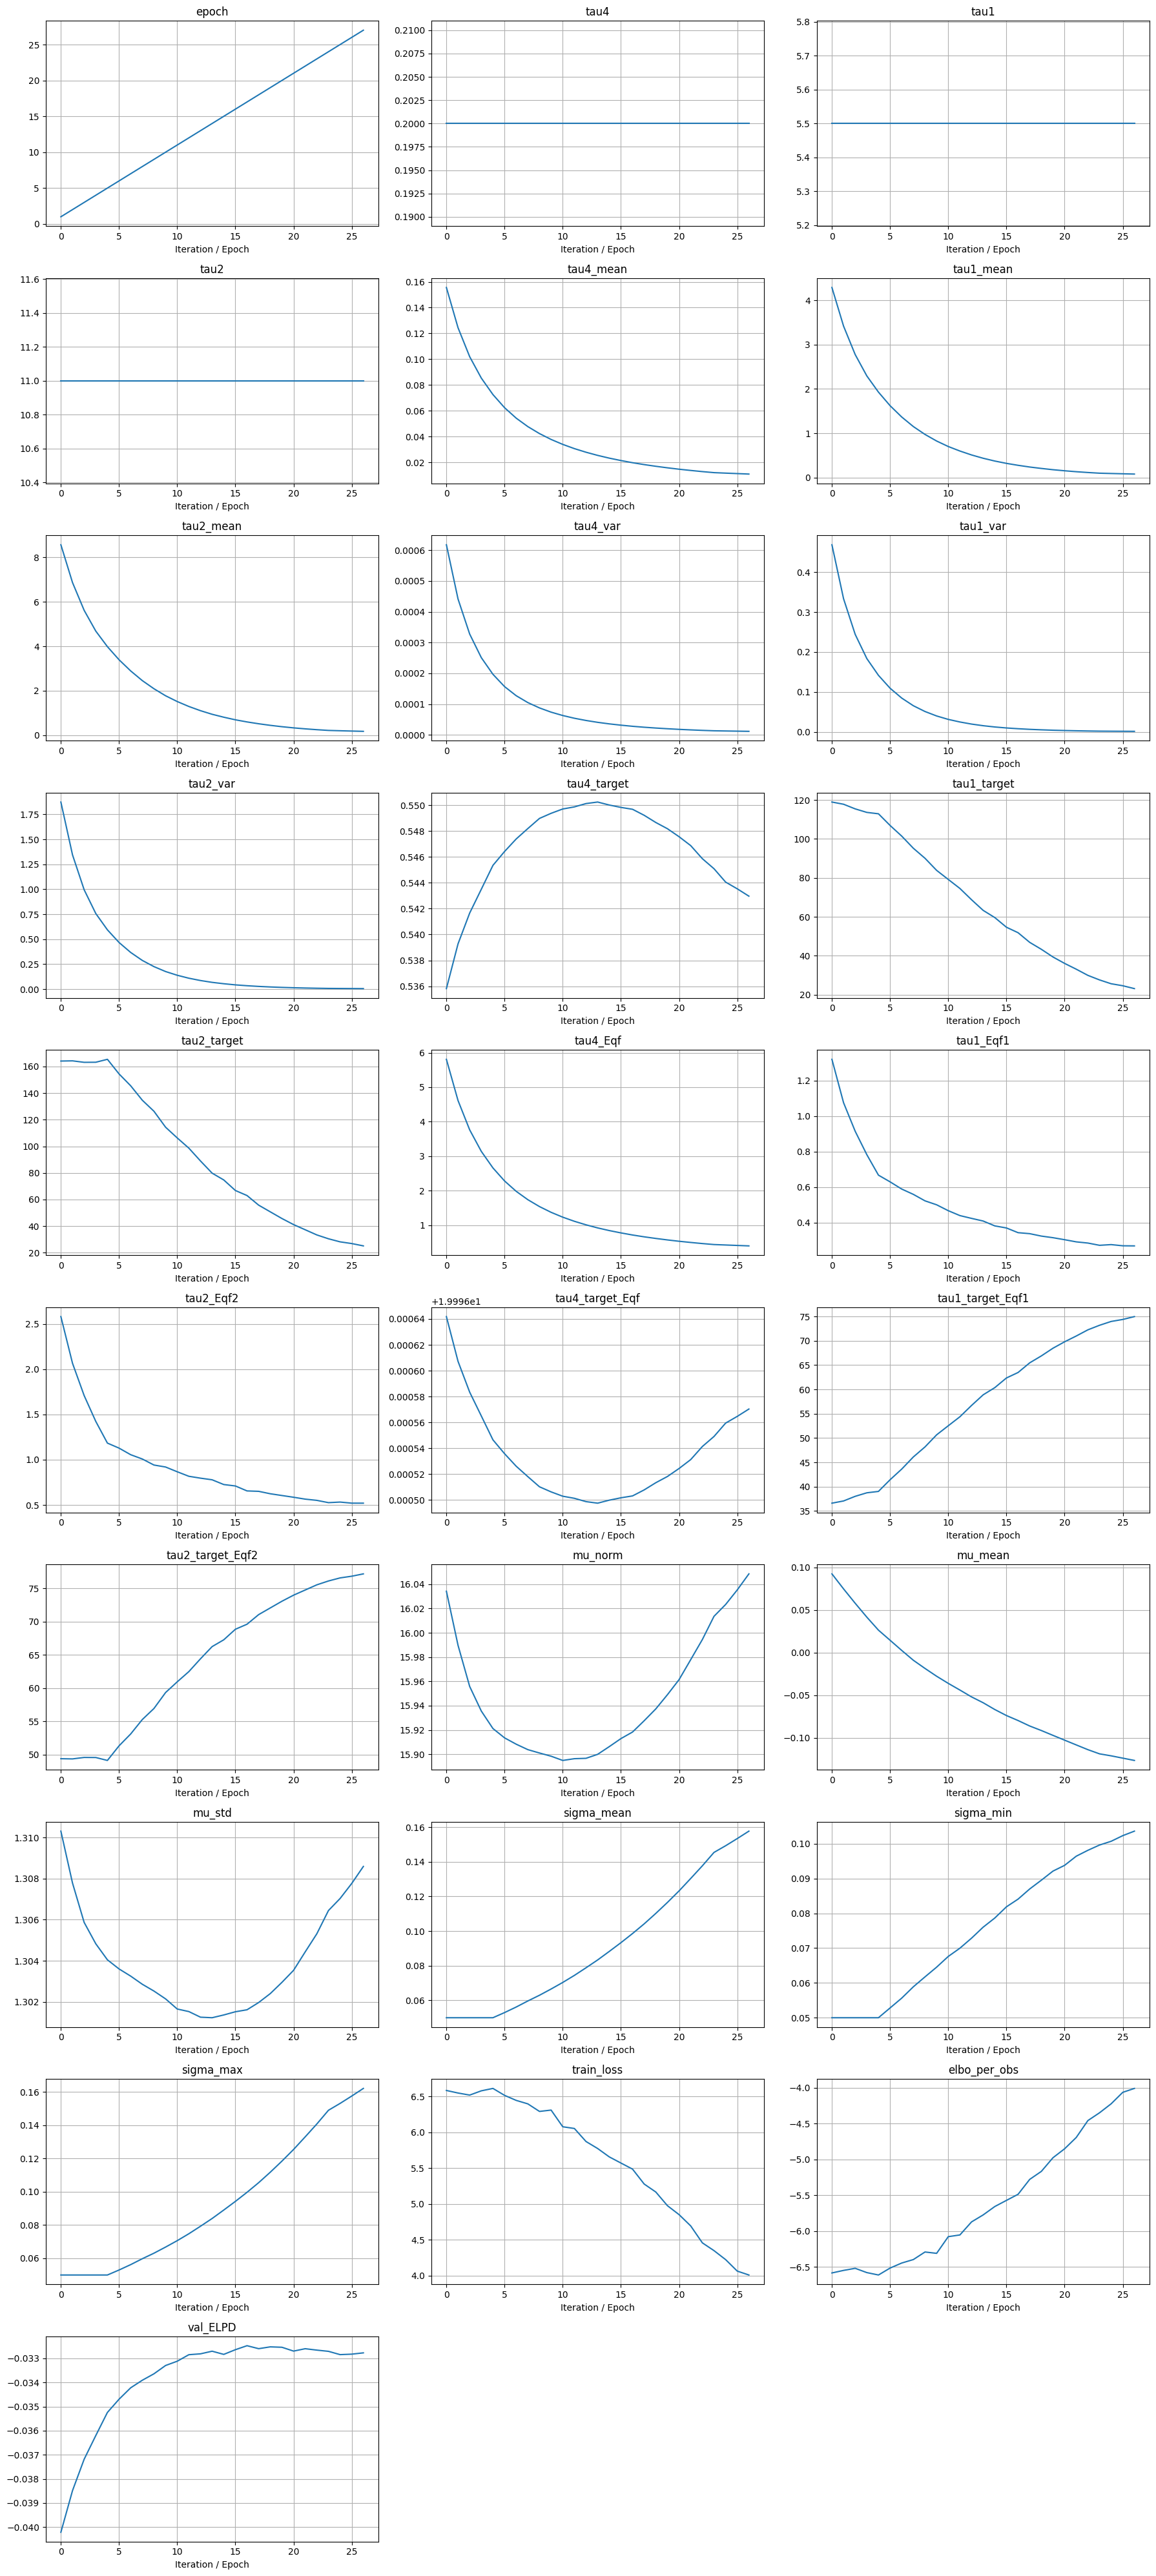

In [22]:

monitor = output["monitor"]

# Filter keys that are plottable (1D numeric sequences)
plot_keys = [k for k, v in monitor.items() if hasattr(v, "__len__") and not isinstance(v, (str, bytes))]

n = len(plot_keys)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, key in zip(axes, plot_keys):
    ax.plot(monitor[key])
    ax.set_title(key)
    ax.set_xlabel("Iteration / Epoch")
    ax.grid(True)

# Hide empty subplots (if any)
for i in range(len(plot_keys), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

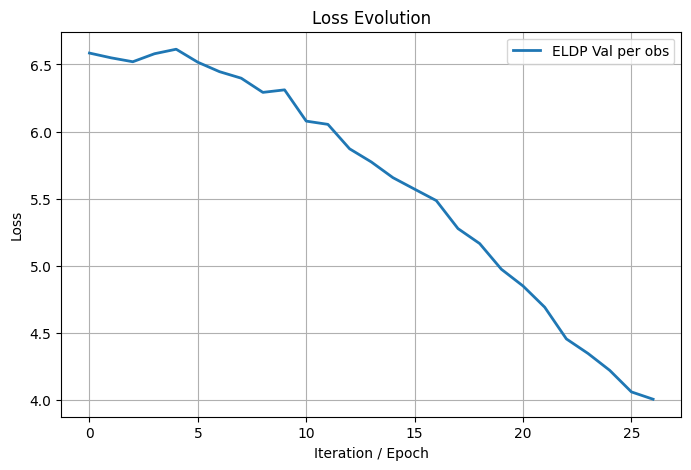

In [21]:

loss_history = output['loss_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [23]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [24]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [25]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM       Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian  Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula    Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM       Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian  Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula    Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.1256
KLD GTM       Train Data:  0.0465
KLD Gaussian  Train Data:  0.0398
KLD Copula    Train Data:  0.7844

KLD BGTM      Test  Data:  0.1494
KLD GTM       Test  Data:  0.0549
KLD Gaussian  Test  Data:  0.0452
KLD Copula    Test  Data:  0.8144


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [26]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

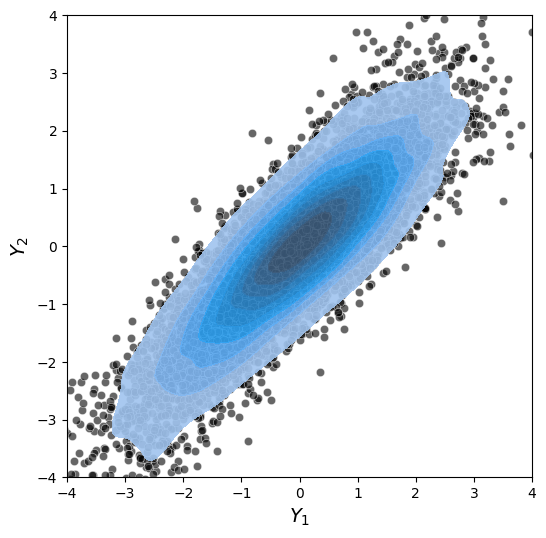

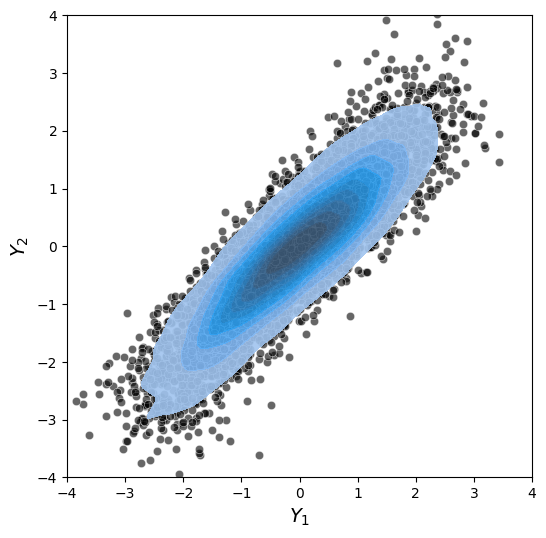

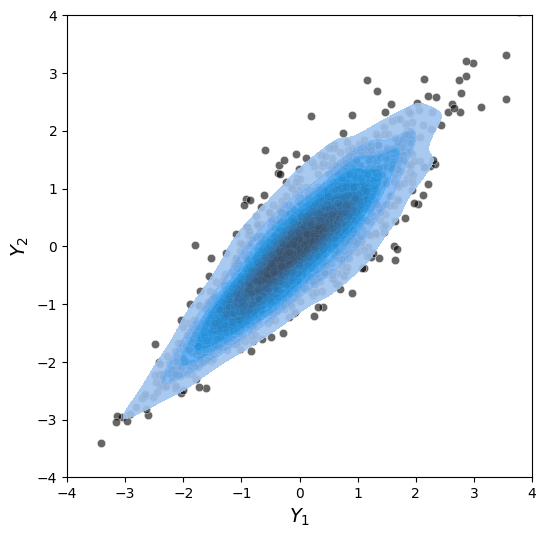

In [17]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [18]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [19]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


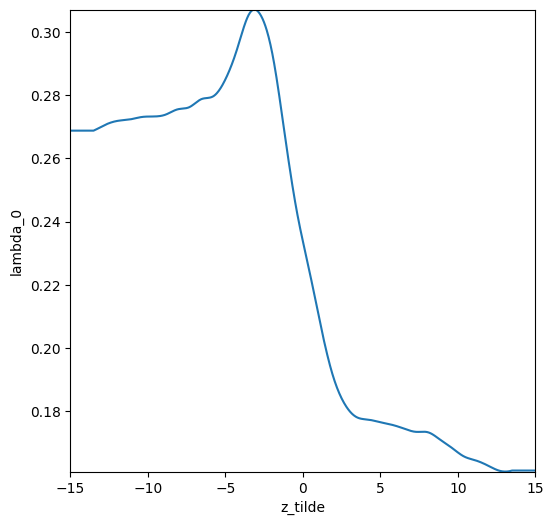

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


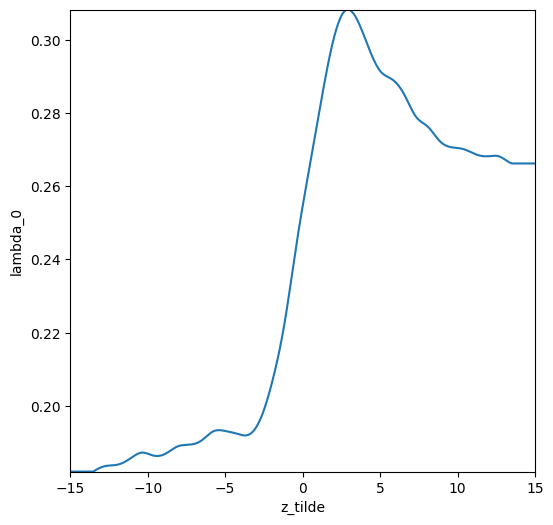

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


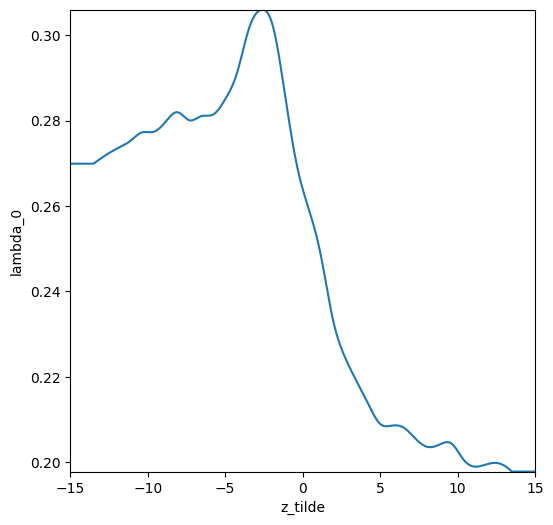

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)